# Enhancing Netflix's Movie Recommendation System through Advanced Hybrid Modeling Techniques

Introduction:

The modern digital entertainment landscape is fiercely competitive, with companies continually seeking innovative strategies to improve user engagement and satisfaction. Netflix, a leader in the streaming industry, faces the challenge of keeping its content both relevant and personalized for its diverse user base. This project aims to revamp Netflix's movie recommendation system by integrating advanced machine learning models that leverage both collaborative filtering and content-based filtering techniques.

The dataset utilized for this project consists of extensive user interaction data provided by Netflix, encompassing millions of user ratings across thousands of movies. By employing a hybrid approach that combines the strengths of both model-based and memory-based filtering techniques, the project seeks to develop a more robust and accurate recommendation engine. This initiative not only aims to enhance user satisfaction through personalized content but also strives to increase viewer retention rates and time spent on the platform.

The scope of this project includes the development of three key model prototypes: a Neural Collaborative Filtering model, a content-based filtering model using advanced feature extraction from movie metadata, and an ensemble model that synthesizes inputs from both to provide finely tuned recommendations. The project will utilize cutting-edge technologies and methodologies, including deep learning frameworks and natural language processing tools, to analyze and predict user preferences with high precision.

The outcome of this project is expected to provide strategic insights into user preferences, enabling Netflix to tailor its content offerings more effectively and maintain its competitive edge in the streaming service market.

In [1]:
# Importing the libraries
import os
import re
import random
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from scipy.stats import skew, kurtosis
from scipy.sparse import csr_matrix

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances

from wordcloud import WordCloud

from gensim import models
from gensim.models import FastText as ft

%matplotlib inline

D:\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Use the %matplotlib inline command sets up the notebook environment to display plots inline.

In [2]:
import warnings

# ignore Warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message="A value is trying to be set on a copy of a slice from a DataFrame")

# 1.Abstract

The project aims to enhance Netflix's movie recommendation system to elevate user engagement and satisfaction. Leveraging the Netflix Movie Recommendations Dataset, the team proposes a comprehensive approach combining collaborative filtering and content-based features through a hybrid deep learning model.

The methodology involves data preparation, collaborative filtering using Neural Collaborative Filtering (NCF), and extraction of content-based features. A deep learning model for content-based recommendations is designed, followed by the creation of a hybrid model seamlessly integrating collaborative and content-based components. The team plans to fine-tune hyperparameters, explore personalization, and contextualization options, and implement robust evaluation metrics for model performance.

Anticipating challenges, the team commits to continuous monitoring and iteration for improvement. The major outcomes sought include a refined recommendation system, backed by statistical analyses and visualizations, contributing to Netflix's sustained success in the dynamic digital entertainment industry. The project emphasizes not only technical excellence but also a user-centric approach to deliver an enriched and personalized streaming experience.

In [3]:
from IPython.display import Image

image_url = 'https://github.com/jiahaoLi00/Data-Science/blob/main/logo.jpeg?raw=true'

# # Display the image
Image(url=image_url)

# 2.Introduction

This project aims to build a movie recommendation mechanism within Netflix. The dataset we used here come directly from Netflix. It consists of 4 text data files and 1 movie title file. Each text data file contains over 20M rows, i.e. over 4K movies and 400K customers. And the movie title file contains all movies occuring to text data files. For reducing running time, we use a sample subset of all the four text files. This will reduce the number of movies and number of users in the dataset, but won't affect performance of models.

This project aims to optimize the recommendation algorithm using a hybrid deep learning approach, combining collaborative filtering and content-based filtering. The ultimate goal is to elevate user engagement, satisfaction, and retention rates by providing more accurate and personalized movie recommendations.

**Research Question:**

The primary 3 research questions guiding this project are:

- **In what ways can we enhance the user engagement of the Netflix movie recommendation system by optimizing the hybrid deep learning approach?**

This question delves into the specific strategies and improvements that can be applied to the recommendation system. It focuses on the nuances of the hybrid deep learning model and how its optimization can lead to enhanced user engagement.

- **What are the critical hyperparameters that require fine-tuning within the hybrid deep learning model for movie recommendations, and how do these adjustments affect the quality of recommendations?**

This question addresses the technical aspects of model optimization. It seeks to identify the key hyperparameters in the hybrid deep learning model, exploring how adjustments to these parameters impact the quality and accuracy of movie recommendations.

- **How can visualizations such as bar charts, scatter plots, and heat maps provide valuable insights into the performance of various recommendation models, ultimately contributing to the enhancement of user engagement?**

This question focuses on the role of visualizations in understanding and communicating the performance of different recommendation models. It aims to leverage visual aids to gain insights into user engagement patterns and iteratively improve the recommendation system.

# 3.Exploratory Data Analysis(EDA):

## Load data
First of all, we load data from local files. Here is the link to download files: https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data. Please follow these steps to put files into a specific path: 
- 1. create new folder, rename it "dataset".
- 2. put all five files we used (combine_data_1.txt, combine_data_2.txt, combine_data_3.txt, combine_data_4.txt, movie_titles.csv) in it.  
- 3. Put the folder "dataset" and the jupyter python file in a same folder

A list of file paths is defined, pointing to the location of the dataset files on local machine. These include four combined_data text files and one movie_titles.csv file.

We load four combined_data files. These files contain three columns: user id, user ratings for movies, and rating date. It is read into rating_data variable. This file has two kinds of rows: user rating rows and movie id rows.  
- For each user rating row, the values in these three columns are normal.  
- For each movie id row, the value of user id column is actually movie id, ending with :. And the values of user ratings column and rating date are empty.


In [4]:
# get current directory
current_file_path = os.path.abspath('__file__')
current_directory = os.path.dirname(current_file_path)

# File path for combined_data_1.txt
file_path1 = os.path.join(current_directory, 'dataset', 'combined_data_1.txt')
# file_path2 = os.path.join(current_directory, 'dataset', 'combined_data_2.txt')
# file_path3 = os.path.join(current_directory, 'dataset', 'combined_data_3.txt')
# file_path4 = os.path.join(current_directory, 'dataset', 'combined_data_4.txt')
file_path5 = os.path.join(current_directory, 'dataset', 'movie_titles.csv')
file_path6 = os.path.join(current_directory, 'dataset', 'tmdb_5000_movies.csv')
# file_paths = [file_path1, file_path2, file_path3, file_path4, file_path5]

# get rating data
rating_data1 = pd.read_csv(file_path1, header=None, names=['UserID', 'Rating', 'Date'], encoding='latin1')
# rating_data2 = pd.read_csv(file_path2, header=None, names=['UserID', 'Rating', 'Date'], encoding='latin1')
# rating_data3 = pd.read_csv(file_path3, header=None, names=['UserID', 'Rating', 'Date'], encoding='latin1')
# rating_data4 = pd.read_csv(file_path4, header=None, names=['UserID', 'Rating', 'Date'], encoding='latin1')
# show a result
rating_data1

,UserID,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26
...,...,...,...
24058258,2591364,2.0,2005-02-16
24058259,1791000,2.0,2005-02-10
24058260,512536,5.0,2005-07-27
24058261,988963,3.0,2005-12-20


## Process combined_data 1 
After understanding the structure of this file, we create a new column: movie id, and restructure it. The new variable is netflix_raw_data, which contains data in all four files.  

In [5]:
# process rating data
# make a copy
rating_df = rating_data1.copy()
# rating_df2 = rating_data2.copy()
# rating_df3 = rating_data3.copy()
# rating_df4 = rating_data4.copy()

# netflix_raw_data = pd.DataFrame([], columns=['UserID','Rating','Date','MovieID'])
# add movieID column and remove invalid rows
# for rating_df in [rating_df1, rating_df2, rating_df3, rating_df4]:
#     rating_df['MovieID'] = np.nan
#     is_movie_id_row = rating_df['UserID'].str.contains(':')
#     rating_df.loc[is_movie_id_row, 'MovieID'] = rating_df['UserID'].str.replace(':', '').astype(np.int64)
#     rating_df['MovieID'] = rating_df['MovieID'].fillna(method='ffill')
#     rating_df.dropna(subset=['Rating'], inplace=True)
#     rating_df['MovieID'] = rating_df['MovieID'].astype(np.int64)
#     netflix_raw_data = pd.concat([netflix_raw_data, rating_df],ignore_index=True)

rating_df['MovieID'] = np.nan
is_movie_id_row = rating_df['UserID'].str.contains(':')
rating_df.loc[is_movie_id_row, 'MovieID'] = rating_df['UserID'].str.replace(':', '').astype(np.int64)
rating_df['MovieID'] = rating_df['MovieID'].fillna(method='ffill')
rating_df.dropna(subset=['Rating'], inplace=True)
rating_df['MovieID'] = rating_df['MovieID'].astype(np.int64)
# netflix_raw_data = pd.concat([netflix_raw_data, rating_df],ignore_index=True)

# show result
rating_df

,UserID,Rating,Date,MovieID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1
...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499
24058259,1791000,2.0,2005-02-10,4499
24058260,512536,5.0,2005-07-27,4499
24058261,988963,3.0,2005-12-20,4499


In [6]:
rating_df.dtypes

UserID      object
Rating     float64
Date        object
MovieID      int64
dtype: object

In [7]:
# how many user in total dataset
len(rating_df['UserID'].unique())

470758

In [8]:
# how many movies in total dataset
len(rating_df['MovieID'].unique())

4499

## Process movie_titles.csv
We then read the movie_titles.csv file, which contains information about movies, including their IDs, release years, and titles. This file is read into a DataFrame named movie_titles, with the specified column names (MovieID, Year, Title). 

In [9]:
# Process movie_titles.csv separately
movie_titles_file = file_path5  # Assuming the last file is movie_titles.csv
movie_titles = pd.read_csv(movie_titles_file, encoding='latin1', header=None, names=['MovieID', 'Year', 'Title'], on_bad_lines='skip')

# just choose movies we selected 
# movie_titles = movie_titles[movie_titles['MovieID'].isin(movie_id_sample)]

# Displaying the first few rows of the movie titles
movie_titles.head()

,MovieID,Year,Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [10]:
movie_titles.dtypes

MovieID      int64
Year       float64
Title       object
dtype: object

In [11]:
movie_titles

,MovieID,Year,Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17429,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17430,17767,2004.0,Fidel Castro: American Experience
17431,17768,2000.0,Epoch
17432,17769,2003.0,The Company


## Process tmdb_5000_movies.csv

In [12]:
movies = pd.read_csv(file_path6)
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [13]:
movies.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object

In [14]:
# set a copy
movies_copy = movies.copy()

## Summary Statistics for Ratings
The statistics on ratings help in understanding general user preferences and behaviors.  
Shows that there are over 30 million ratings.  
The average rating is around 3.60, suggesting a generally positive response from users.  
The standard deviation is about 1.04, indicating a moderate spread of ratings.  
Ratings range from 1 to 5, with 25% of ratings at 3 or below, 50% at 4, and 75% also at 4.  

In [15]:
# Summary statistics for ratings
rating_df['Rating'].describe()

count    2.405376e+07
mean     3.599634e+00
std      1.086118e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

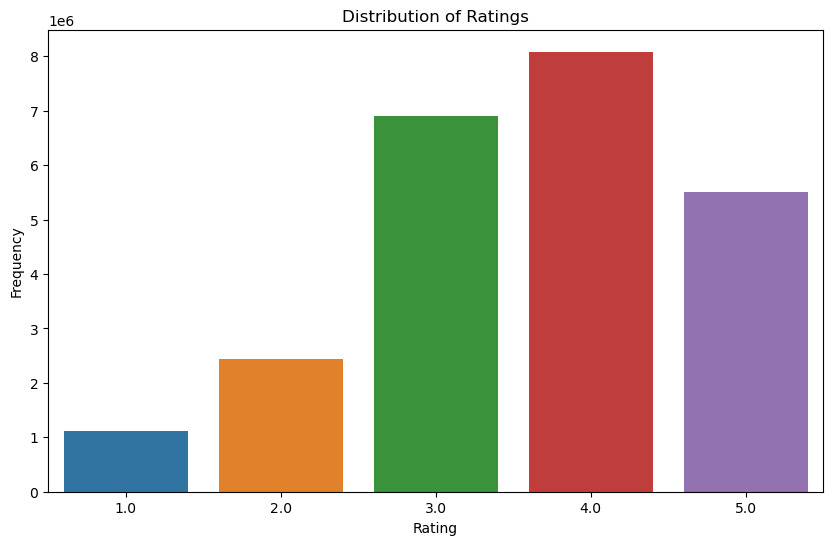

In [16]:
# Rating = data['Rating'].value_counts()
Rating = rating_df['Rating'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=Rating.index, y=Rating.values)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

<AxesSubplot:ylabel='Rating'>

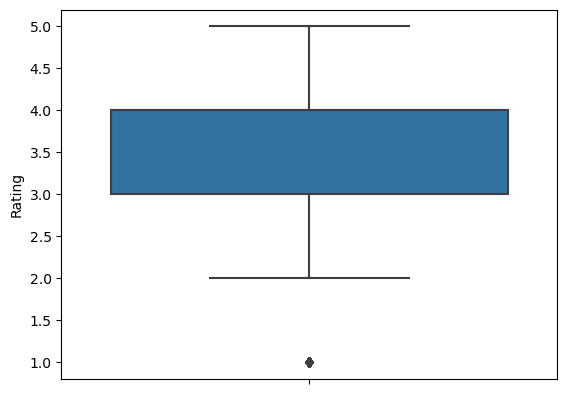

In [17]:
sns.boxplot(y=rating_df['Rating'])

Since 4.0 is the most frequent rating, it might be indicative of a general user satisfaction with the movies. In a recommendation system, movies with higher average ratings like this might be recommended more often.  
The skewness towards higher ratings could be taken into account when developing algorithms, as it might reflect a user bias towards positive ratings.  
Understanding this distribution is crucial for Collaborative Filtering approaches, as it will impact the similarity measures between users or items.

## Movie title frequency

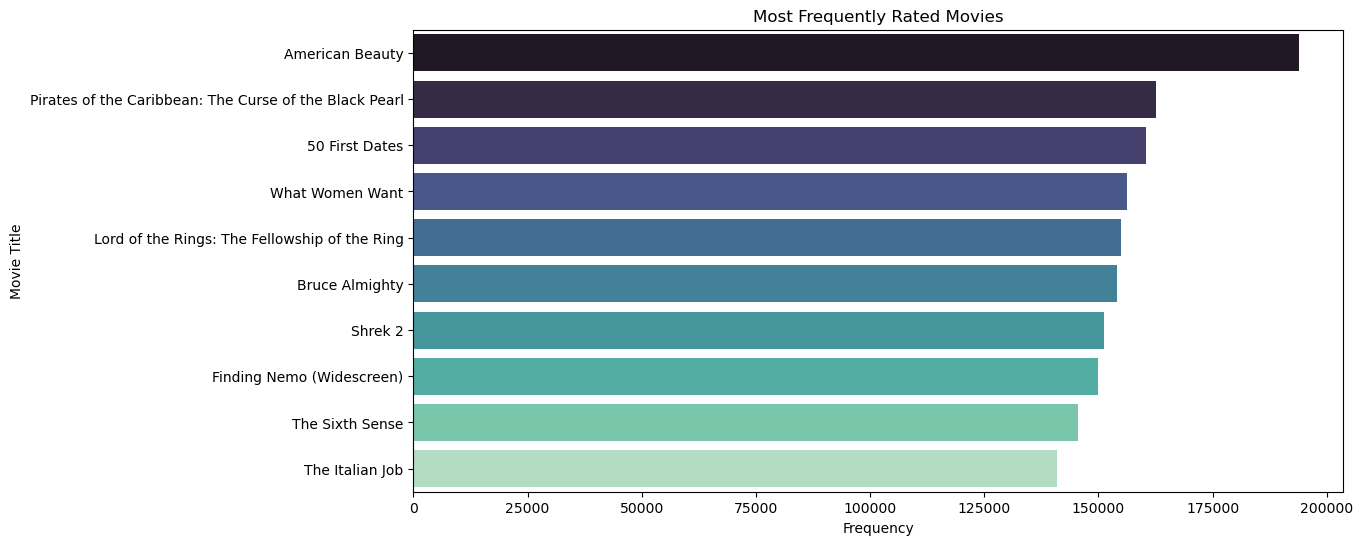

In [18]:
# show top 10 movies frequency
movie_frequency = rating_df['MovieID'].value_counts().head(10)
movie_frequency.index = movie_titles[movie_titles['MovieID'].isin(movie_frequency.index)]['Title']

plt.figure(figsize=(12, 6))
sns.barplot(x=movie_frequency.values, y=movie_frequency.index, palette='mako')
plt.title('Most Frequently Rated Movies')
plt.xlabel('Frequency')
plt.ylabel('Movie Title')
plt.show()

The most frequently rated movie is 'Pirates of the Caribbean: The Curse of the Black Pearl', suggesting it has high user engagement and could be a popular choice to include in recommendation lists.  

Usage in Recommendation Systems: Knowing the most frequently rated movies is valuable information for both collaborative and content-based filtering:  
Collaborative Filtering: Movies with more ratings may provide a more reliable user-item interaction dataset, which can improve the accuracy of predictions for user preferences.   
Content-Based Filtering: High-frequency movies could be more worthy to be analyzed for their content (such as genres, actors, directors) to identify characteristics that appeal to a wide audience.  

## Movie number trend
See the movie release trend

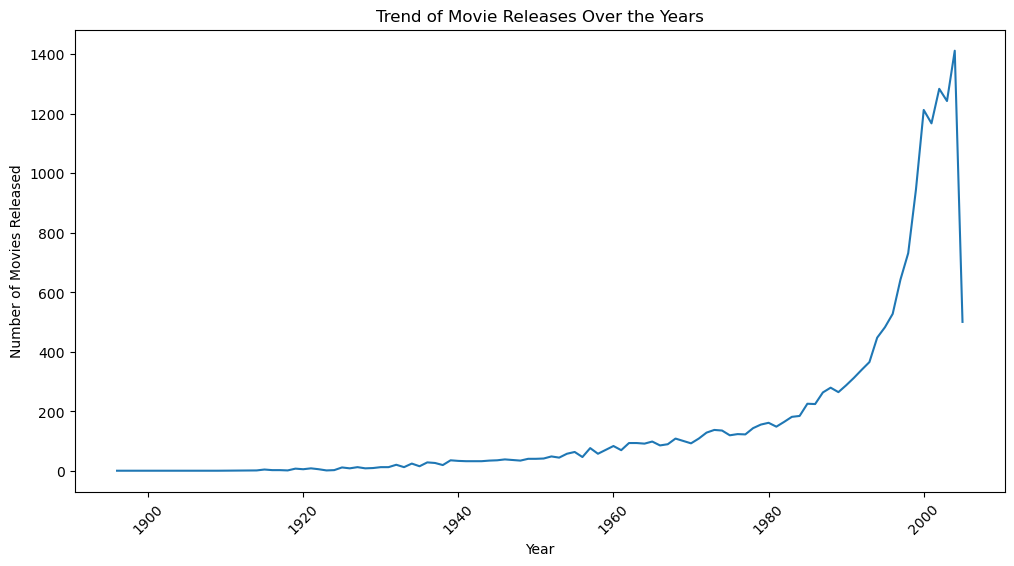

In [19]:
movie_release_trend = movie_titles['Year'].value_counts()
plt.figure(figsize=(12, 6))
sns.lineplot(x=movie_release_trend.index, y=movie_release_trend.values)
plt.title('Trend of Movie Releases Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.xticks(rotation=45)
plt.show()

Displays a line chart titled "Trend of Movie Releases Over the Years," which illustrates the number of movies released over time. The x-axis represents years, and the y-axis represents the count of movies released in those years.

From the chart, we can make several observations:  
- Long-Term Trend: There is a clear upward trend in the number of movies released annually over the years. This likely reflects the growth of the film industry and the increasing capacity for movie production and distribution.  
- Early Years Stability: In the early years (around 1920 to the mid-20th century), the number of movies released each year appears relatively stable and low. This period might correspond to the infancy of the film industry when production capabilities were limited.  
- Acceleration in Later Years: Starting around the 1960s, there is a noticeable increase in the slope of the line, indicating a rise in the number of movies being released. The trend accelerates particularly from the 1980s onwards.  
- Sharp Increase Towards the 2000s: There is a sharp rise as we approach the 2000s, peaking just before 2010. This could be due to several factors, including technological advancements, the proliferation of digital filmmaking, and the growth of global markets for movies.  
- Sudden Drop: There is a sudden drop in the number of movies released just after the peak. This abrupt change could be due to data collection issues, a significant event in the film industry, or possibly a transition period to new formats or distribution channels.  

# 4.Data Preparation

## Convert UserID into int

In [20]:
rating_df.dtypes

UserID      object
Rating     float64
Date        object
MovieID      int64
dtype: object

It is object type. Convert it into int.

In [21]:
rating_df['UserID'] = rating_df['UserID'].astype('int')
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24053764 entries, 1 to 24058262
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   UserID   int32  
 1   Rating   float64
 2   Date     object 
 3   MovieID  int64  
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 825.8+ MB


It is int type now.

## Planning for Data Integrity and Consistency Checks
With these data in hand, we can plan for integrity checks. For instance, ensuring that movie IDs in the subset data match those in the movie_titles.csv. This is essential for maintaining data accuracy, especially when merging datasets or linking user ratings to specific movies.

In [22]:
# select movies occuring to both two movie files
movie_selected = movie_titles[movie_titles['Title'].isin(movies['title'])]
movie_selected.head()

,MovieID,Year,Title
2,3,1997.0,Character
23,24,1981.0,My Bloody Valentine
29,30,2003.0,Something's Gotta Give
44,45,1999.0,The Love Letter
54,55,1995.0,Jade


In [23]:
rating_selected = rating_df[rating_df['MovieID'].isin(movie_selected['MovieID'])]
rating_selected.head()

,UserID,Rating,Date,MovieID
695,1025579,4.0,2003-03-29,3
696,712664,5.0,2004-02-01,3
697,1331154,4.0,2004-07-03,3
698,2632461,3.0,2005-07-22,3
699,44937,5.0,2004-06-22,3


In [24]:
user_num = len(rating_selected['UserID'].unique())
movie_num = len(movie_selected['MovieID'].unique())
pd.DataFrame([user_num,movie_num],columns=['number'],index=['user','movie'])

,number
user,461030
movie,2222


There are 461030 users and 2222 movies left before sampling.

## Sample data
Using all the data to do EDA and model development will take too long. We determine to sample the data.  
We use a mixed sampling strategy, which contains Stratified Sampling and Random Sampling:
- Stratified Sampling: we stratify the data based on popular movies and active users. And we choose all popular movies and active users. This ensures that the user rating matrix is not too sparse.  
- Random Sampling: for less popular movies and less active users, we randomly choose some observation. This ensures our subset can represent all popular and unpopular movies and active and unactive users.

In details, we choose top 800 popular movies and randomly choose 200 less popular movies. We also choose top 80000 active users and less active 20000 users. The subset is not only unsparse, but also representative.

In [25]:
# get 100 movis

np.random.seed(123)

# choose top 80 popular movies 
popular_movie_id = rating_selected['MovieID'].value_counts()[:80].index
popular_movie_id = list(popular_movie_id)

# randomly sample 20 of the remaining less popular movies
unpopular_movie_id = rating_selected['MovieID'].value_counts()[80:].index
unpopular_movie_id_sample = np.random.choice(unpopular_movie_id, 20, replace=False)
unpopular_movie_id_sample = list(unpopular_movie_id_sample)

# get 1000 movies id
movie_id_sample = popular_movie_id + unpopular_movie_id_sample

In [26]:
# get 500 users

# choose top 400 most active users
active_user_id = rating_selected['UserID'].value_counts()[:400].index
active_user_id = list(active_user_id)

# randomly sample 100 of the remaining less active users
unactive_user_id = rating_selected['UserID'].value_counts()[400:].index
unactive_user_id_sample = np.random.choice(unactive_user_id, 100, replace=False)
unactive_user_id_sample = list(unactive_user_id_sample)

# get 500 users id
user_id_sample = active_user_id + unactive_user_id_sample

In [27]:
# get subset which contains 100 movies and 500 users 
subset = rating_selected[(rating_selected['MovieID'].isin(movie_id_sample)) & (rating_selected['UserID'].isin(user_id_sample))]

user_number = len(subset['UserID'].unique())
movie_number = len(subset['MovieID'].unique())
f'User: {user_number}', f'Movie: {movie_number}'

('User: 499', 'Movie: 100')

We can see the subset contains 1000 movies and 99874 users. The number of users is less than expected because some selected users don't rate these selected movies. This is  in line with our sampling strategy and we don't need to modify it.

In [28]:
subset.head()

,UserID,Rating,Date,MovieID
92836,306466,3.0,2004-04-02,30
92946,1174530,4.0,2004-04-06,30
93167,1744889,3.0,2005-06-02,30
93558,461110,4.0,2004-05-04,30
94050,327122,4.0,2005-12-12,30


## Merge files
Merge subset and movie_selected on MovieID.  
Merge merge1 and movies on Title.

In [29]:
# see image
image_url='https://github.com/jiahaoLi00/Data-Science/blob/main/combine%20files.png?raw=true'
Image(url=image_url)

In [30]:
# merge subset and movie_selected by movieID
merge1 = pd.merge(subset, movie_selected, on='MovieID')

# merge movies by title
merge2 = pd.merge(merge1, movies, left_on='Title', right_on='title')

In [31]:
# make a checkpoint
data = merge2.copy()

## Have a look at the subset data.

In [32]:
data.head()

,UserID,Rating,Date,MovieID,Year,Title,budget,genres,homepage,id,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,306466,3.0,2004-04-02,30,2003.0,Something's Gotta Give,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",NaN,6964,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-12-12,266728738,128.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Schmucks are people too.,Something's Gotta Give,6.3,410
1,1174530,4.0,2004-04-06,30,2003.0,Something's Gotta Give,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",NaN,6964,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-12-12,266728738,128.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Schmucks are people too.,Something's Gotta Give,6.3,410
2,1744889,3.0,2005-06-02,30,2003.0,Something's Gotta Give,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",NaN,6964,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-12-12,266728738,128.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Schmucks are people too.,Something's Gotta Give,6.3,410
3,461110,4.0,2004-05-04,30,2003.0,Something's Gotta Give,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",NaN,6964,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-12-12,266728738,128.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Schmucks are people too.,Something's Gotta Give,6.3,410
4,327122,4.0,2005-12-12,30,2003.0,Something's Gotta Give,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",NaN,6964,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-12-12,266728738,128.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Schmucks are people too.,Something's Gotta Give,6.3,410


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34285 entries, 0 to 34284
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   UserID                34285 non-null  int32  
 1   Rating                34285 non-null  float64
 2   Date                  34285 non-null  object 
 3   MovieID               34285 non-null  int64  
 4   Year                  34285 non-null  float64
 5   Title                 34285 non-null  object 
 6   budget                34285 non-null  int64  
 7   genres                34285 non-null  object 
 8   homepage              10988 non-null  object 
 9   id                    34285 non-null  int64  
 10  keywords              34285 non-null  object 
 11  original_language     34285 non-null  object 
 12  original_title        34285 non-null  object 
 13  overview              34285 non-null  object 
 14  popularity            34285 non-null  float64
 15  production_companie

UserID and MovieID are int type.  
features genres, keywords, overview and title which we will use are object type.

In [34]:
data.shape

(34285, 26)

## Handle missing value

In [35]:
# Check for null values in the combined data
data.isnull().sum()

UserID                      0
Rating                      0
Date                        0
MovieID                     0
Year                        0
Title                       0
budget                      0
genres                      0
homepage                23297
id                          0
keywords                    0
original_language           0
original_title              0
overview                    0
popularity                  0
production_companies        0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline                  2240
title                       0
vote_average                0
vote_count                  0
dtype: int64

In [36]:
# drop these features containing missing
data.drop(columns=['homepage','tagline'], inplace=True)
data.isnull().sum()

UserID                  0
Rating                  0
Date                    0
MovieID                 0
Year                    0
Title                   0
budget                  0
genres                  0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
vote_average            0
vote_count              0
dtype: int64

There is no missing value now.

## Duplicate Row Check
Indicates there are no duplicate rows, confirming the uniqueness of each data entry.

In [37]:
# Check for duplicate rows in the combined data
data.duplicated().sum()

0

## Drop unused and duplicated columns
Drop some obviously unused columns to reduce its memory.  
- We will use MovieID instead of id.  
- We will not use release_date as a feature to recommend movies.
- We use title instead of Title as movie title.

In [38]:
data.drop(columns=['id','release_date','Title'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34285 entries, 0 to 34284
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   UserID                34285 non-null  int32  
 1   Rating                34285 non-null  float64
 2   Date                  34285 non-null  object 
 3   MovieID               34285 non-null  int64  
 4   Year                  34285 non-null  float64
 5   budget                34285 non-null  int64  
 6   genres                34285 non-null  object 
 7   keywords              34285 non-null  object 
 8   original_language     34285 non-null  object 
 9   original_title        34285 non-null  object 
 10  overview              34285 non-null  object 
 11  popularity            34285 non-null  float64
 12  production_companies  34285 non-null  object 
 13  production_countries  34285 non-null  object 
 14  revenue               34285 non-null  int64  
 15  runtime            

## Create user rating matrix
Many collaborative filter algorithms need a user rating matrix as input data. Transform data into this format.

In [39]:
# Pivot the data to create a matrix where rows are users and columns are movies
user_rating_matrix = data.pivot_table(index='UserID', columns='MovieID', values='Rating')

# Display the first few rows of the matrix
user_rating_matrix.head()

MovieID,30,166,175,299,312,313,329,357,457,482,...,4043,4123,4216,4266,4306,4315,4345,4356,4432,4472
UserID,,,,,,,,,,,,,,,,,,,,,
1333,3.0,NaN,3.0,1.0,3.0,3.0,3.0,5.0,2.0,1.0,...,2.0,NaN,1.0,3.0,5.0,3.0,1.0,4.0,2.0,5.0
3321,5.0,3.0,NaN,4.0,NaN,NaN,4.0,2.0,4.0,NaN,...,4.0,4.0,4.0,4.0,5.0,4.0,NaN,4.0,NaN,2.0
10268,3.0,NaN,4.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,...,4.0,4.0,3.0,5.0,3.0,4.0,NaN,3.0,4.0,4.0
10374,4.0,NaN,4.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,...,5.0,5.0,5.0,5.0,5.0,NaN,NaN,5.0,4.0,5.0
11043,5.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,3.0,NaN,...,4.0,5.0,3.0,4.0,4.0,4.0,NaN,5.0,5.0,4.0


There are multiple NaN values, which mean users haven't rated these movies. And the aim of our algorithm is to predict these NaN values.

## Sample data again to repeatedly test

In [40]:
def get_sample(seed, popular_num, unpopular_num, active_num, unactive_num,rating_selected=rating_selected,movies=movies_copy):
    """get sample subset from data
    ------------------------------------------------
    seed: random seed
    popular_num: the number of choosing popular movies
    unpopular_num: the number of choosing unpopular movies
    active_num: the number of choosing active users 
    unactive_num: the number of choosing unactive users
    """
    np.random.seed(seed)

    # choose top 80 popular movies 
    popular_movie_id = rating_selected['MovieID'].value_counts()[:popular_num].index
    popular_movie_id = list(popular_movie_id)

    # randomly sample 20 of the remaining less popular movies
    unpopular_movie_id = rating_selected['MovieID'].value_counts()[popular_num:].index
    unpopular_movie_id_sample = np.random.choice(unpopular_movie_id, unpopular_num, replace=False)
    unpopular_movie_id_sample = list(unpopular_movie_id_sample)

    # get 100 movies id
    movie_id_sample = popular_movie_id + unpopular_movie_id_sample
    
    # choose top 400 most active users
    active_user_id = rating_selected['UserID'].value_counts()[:active_num].index
    active_user_id = list(active_user_id)

    # randomly sample 100 of the remaining less active users
    unactive_user_id = rating_selected['UserID'].value_counts()[active_num:].index
    unactive_user_id_sample = np.random.choice(unactive_user_id, unactive_num, replace=False)
    unactive_user_id_sample = list(unactive_user_id_sample)

    # get 500 users id
    user_id_sample = active_user_id + unactive_user_id_sample
    
    # get subset which contains 100 movies and 500 users 
    subset = rating_selected[(rating_selected['MovieID'].isin(movie_id_sample)) & (rating_selected['UserID'].isin(user_id_sample))]

    user_number = len(subset['UserID'].unique())
    movie_number = len(subset['MovieID'].unique())
    print(f'User: {user_number}', f'Movie: {movie_number}')
    
    # merge subset and movie_selected by movieID
    merge1 = pd.merge(subset, movie_selected, on='MovieID')

    # merge movies by title
    merge2 = pd.merge(merge1, movies, left_on='Title', right_on='title')
    
    # make a checkpoint
    data = merge2.copy()
    
    data.drop(columns=['homepage','tagline','id','release_date','Title'], inplace=True)
    
    return data

Try to get some samples using this function.

In [41]:
# different random seed but same sample size
data1 = get_sample(seed=10, popular_num=80, unpopular_num=20, active_num=400, unactive_num=100)

# different random seed and different sample size
data2 = get_sample(seed=40, popular_num=150, unpopular_num=50, active_num=800, unactive_num=200)

User: 497 Movie: 100
User: 999 Movie: 200


# 5. Prep data review

## See top 10 rating movies

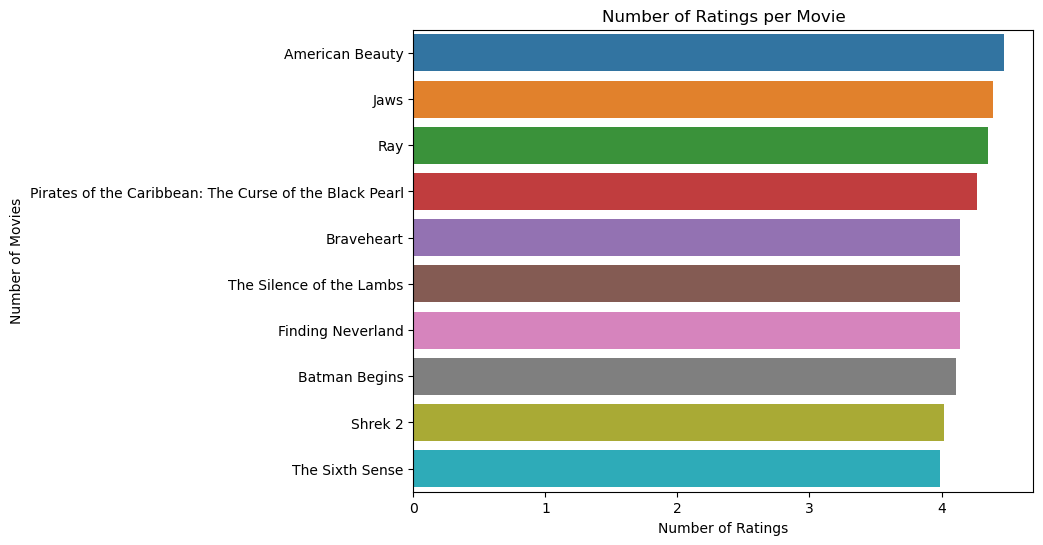

In [42]:
# Top 10 rating movies
movie_mean_ratings = data.groupby('MovieID')['Rating'].mean()
top10_rating_movies = movie_mean_ratings.sort_values(ascending=False)[:10]
top10_rating_movies.index = movie_titles[movie_titles['MovieID'].isin(top10_rating_movies.index)]['Title']

plt.figure(figsize=(8, 6))
sns.barplot(x=top10_rating_movies.values, y=top10_rating_movies.index)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

These movies are top 10 rating movies. We can see "American Beauty" has highest rating.

## Correlation between rating and year
To see if there is obvious correlation between rating and year.

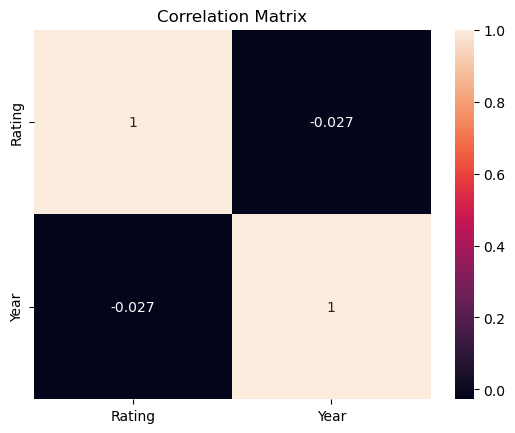

In [43]:
# Correlation Matrix for Numeric Features
numeric_data = data[['Rating', 'Year']]  
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

No obvious correlation. This makes sense.

# 6. Machine Learning Models 
## 6.1 Content Based Recommender System
### memory based

**Research Question 1:**

**In what ways can we enhance the user engagement of the Netflix movie recommendation system by optimizing the hybrid deep learning approach?**

*Hybrid Approach:** By combining the scaled weighted average and popularity scores, we created a hybrid scoring mechanism for movie recommendations. This method aims to balance both critical factors—movie quality (weighted average) and overall popularity—when suggesting movies to users. This balanced approach could improve engagement by catering to different user preferences.

**Content-Based Recommendation System:** Implementing a content-based recommendation system using movie plot summaries can further engage users by suggesting movies based on similarity in content or themes, potentially offering more personalized recommendations.

In [44]:
# create a specific variable to build content based model
movies_selected_title = data['title'].unique()
movies_selected = movies[movies['title'].isin(movies_selected_title)]
movies_selected.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
119,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www2.warnerbros.com/batmanbegins/index....,272,"[{""id"": 486, ""name"": ""himalaya""}, {""id"": 779, ...",en,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded...",115.040024,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2005-06-10,374218673,140.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Evil fears the knight.,Batman Begins,7.5,7359
149,140000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",NaN,95,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Armageddon,When an asteroid threatens to collide with Ear...,58.485967,"[{""name"": ""Jerry Bruckheimer Films"", ""id"": 130...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1998-07-01,553799566,151.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The Earth's Darkest Day Will Be Man's Finest Hour,Armageddon,6.4,2482
150,140000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/homevideo/meninbla...,608,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Men in Black II,"Kay and Jay reunite to provide our best, last ...",91.332849,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-07-03,441818803,88.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Same Planet. New Scum.,Men in Black II,6.0,3114
156,140000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",NaN,616,"[{""id"": 233, ""name"": ""japan""}, {""id"": 1327, ""n...",en,The Last Samurai,Nathan Algren is an American hired to instruct...,52.341226,"[{""name"": ""Cruise/Wagner Productions"", ""id"": 4...","[{""iso_3166_1"": ""JP"", ""name"": ""Japan""}, {""iso_...",2003-12-05,456758981,154.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"In the face of an enemy, in the heart of one m...",The Last Samurai,7.3,1895
186,130000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",NaN,8961,"[{""id"": 416, ""name"": ""miami""}, {""id"": 529, ""na...",en,Bad Boys II,"Out-of-control, trash-talking buddy cops Marcu...",38.068736,"[{""name"": ""Columbia Pictures Corporation"", ""id...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-07-18,273339556,147.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"If you can't stand the heat, get out of Miami.",Bad Boys II,6.3,1564


In [45]:
movies_selected.shape

(100, 20)

In [46]:
movies_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 119 to 4773
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                100 non-null    int64  
 1   genres                100 non-null    object 
 2   homepage              31 non-null     object 
 3   id                    100 non-null    int64  
 4   keywords              100 non-null    object 
 5   original_language     100 non-null    object 
 6   original_title        100 non-null    object 
 7   overview              100 non-null    object 
 8   popularity            100 non-null    float64
 9   production_companies  100 non-null    object 
 10  production_countries  100 non-null    object 
 11  release_date          100 non-null    object 
 12  revenue               100 non-null    int64  
 13  runtime               100 non-null    float64
 14  spoken_languages      100 non-null    object 
 15  status              

In [47]:
movies_selected.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
119,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www2.warnerbros.com/batmanbegins/index....,272,"[{""id"": 486, ""name"": ""himalaya""}, {""id"": 779, ...",en,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded...",115.040024,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2005-06-10,374218673,140.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Evil fears the knight.,Batman Begins,7.5,7359
149,140000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",NaN,95,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Armageddon,When an asteroid threatens to collide with Ear...,58.485967,"[{""name"": ""Jerry Bruckheimer Films"", ""id"": 130...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1998-07-01,553799566,151.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The Earth's Darkest Day Will Be Man's Finest Hour,Armageddon,6.4,2482
150,140000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/homevideo/meninbla...,608,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Men in Black II,"Kay and Jay reunite to provide our best, last ...",91.332849,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-07-03,441818803,88.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Same Planet. New Scum.,Men in Black II,6.0,3114
156,140000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",NaN,616,"[{""id"": 233, ""name"": ""japan""}, {""id"": 1327, ""n...",en,The Last Samurai,Nathan Algren is an American hired to instruct...,52.341226,"[{""name"": ""Cruise/Wagner Productions"", ""id"": 4...","[{""iso_3166_1"": ""JP"", ""name"": ""Japan""}, {""iso_...",2003-12-05,456758981,154.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"In the face of an enemy, in the heart of one m...",The Last Samurai,7.3,1895
186,130000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",NaN,8961,"[{""id"": 416, ""name"": ""miami""}, {""id"": 529, ""na...",en,Bad Boys II,"Out-of-control, trash-talking buddy cops Marcu...",38.068736,"[{""name"": ""Columbia Pictures Corporation"", ""id...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-07-18,273339556,147.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"If you can't stand the heat, get out of Miami.",Bad Boys II,6.3,1564


In [48]:
movies_selected.duplicated().sum()

0

In [49]:
# genres
#id
#keywords
#title
#overview


In [50]:
movies = movies_selected[['id','title','overview','genres','keywords']]

In [51]:
movies.head()

,id,title,overview,genres,keywords
119,272,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 486, ""name"": ""himalaya""}, {""id"": 779, ..."
149,95,Armageddon,When an asteroid threatens to collide with Ear...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...","[{""id"": 83, ""name"": ""saving the world""}, {""id""..."
150,608,Men in Black II,"Kay and Jay reunite to provide our best, last ...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 83, ""name"": ""saving the world""}, {""id""..."
156,616,The Last Samurai,Nathan Algren is an American hired to instruct...,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...","[{""id"": 233, ""name"": ""japan""}, {""id"": 1327, ""n..."
186,8961,Bad Boys II,"Out-of-control, trash-talking buddy cops Marcu...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...","[{""id"": 416, ""name"": ""miami""}, {""id"": 529, ""na..."


In [52]:
movies.isnull().sum()

id          0
title       0
overview    0
genres      0
keywords    0
dtype: int64

In [53]:
movies.duplicated().sum()

0

In [54]:
movies.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 80, "name": "Crime"}, {"id": 18, "name": "Drama"}]'

In [55]:
def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

In [56]:
import ast 
ast.literal_eval


<function ast.literal_eval(node_or_string)>

In [57]:
movies['genres'] = movies['genres'].apply(convert)

C:\Users\dell\AppData\Local\Temp\ipykernel_30164\1189516248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres'] = movies['genres'].apply(convert)


In [58]:
movies['keywords'] = movies['keywords'].apply(convert)

C:\Users\dell\AppData\Local\Temp\ipykernel_30164\3328512696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['keywords'] = movies['keywords'].apply(convert)


In [59]:
movies.head()

,id,title,overview,genres,keywords
119,272,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded...","[Action, Crime, Drama]","[himalaya, martial arts, dc comics, crime figh..."
149,95,Armageddon,When an asteroid threatens to collide with Ear...,"[Action, Thriller, Science Fiction, Adventure]","[saving the world, paris, moon, cataclysm, ast..."
150,608,Men in Black II,"Kay and Jay reunite to provide our best, last ...","[Action, Adventure, Comedy, Science Fiction]","[saving the world, secret identity, sun glasse..."
156,616,The Last Samurai,Nathan Algren is an American hired to instruct...,"[Drama, Action, War, History]","[japan, war crimes, sense of guilt, swordplay,..."
186,8961,Bad Boys II,"Out-of-control, trash-talking buddy cops Marcu...","[Adventure, Action, Comedy, Thriller, Crime]","[miami, ku klux klan, cuba, undercover, mexica..."


In [60]:
# convert overview column from string to list
movies['overview'] = movies['overview'].apply(lambda x:x.split())

C:\Users\dell\AppData\Local\Temp\ipykernel_30164\1786229884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['overview'] = movies['overview'].apply(lambda x:x.split())


In [61]:
movies['genres'] = movies['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x:[i.replace(" ","") for i in x])

C:\Users\dell\AppData\Local\Temp\ipykernel_30164\1816919654.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres'] = movies['genres'].apply(lambda x:[i.replace(" ","") for i in x])
C:\Users\dell\AppData\Local\Temp\ipykernel_30164\1816919654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['keywords'] = movies['keywords'].apply(lambda x:[i.replace(" ","") for i in x])


In [62]:
movies.shape

(100, 5)

In [63]:
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords']

C:\Users\dell\AppData\Local\Temp\ipykernel_30164\3777230669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords']


In [64]:
movies.head()

,id,title,overview,genres,keywords,tags
119,272,Batman Begins,"[Driven, by, tragedy,, billionaire, Bruce, Way...","[Action, Crime, Drama]","[himalaya, martialarts, dccomics, crimefighter...","[Driven, by, tragedy,, billionaire, Bruce, Way..."
149,95,Armageddon,"[When, an, asteroid, threatens, to, collide, w...","[Action, Thriller, ScienceFiction, Adventure]","[savingtheworld, paris, moon, cataclysm, aster...","[When, an, asteroid, threatens, to, collide, w..."
150,608,Men in Black II,"[Kay, and, Jay, reunite, to, provide, our, bes...","[Action, Adventure, Comedy, ScienceFiction]","[savingtheworld, secretidentity, sunglasses, u...","[Kay, and, Jay, reunite, to, provide, our, bes..."
156,616,The Last Samurai,"[Nathan, Algren, is, an, American, hired, to, ...","[Drama, Action, War, History]","[japan, warcrimes, senseofguilt, swordplay, ge...","[Nathan, Algren, is, an, American, hired, to, ..."
186,8961,Bad Boys II,"[Out-of-control,, trash-talking, buddy, cops, ...","[Adventure, Action, Comedy, Thriller, Crime]","[miami, kukluxklan, cuba, undercover, mexicans...","[Out-of-control,, trash-talking, buddy, cops, ..."


In [65]:
movies.reset_index(drop=True, inplace=True)


In [66]:
#we need only following columns for our model building
new_df = movies[['id','title','tags']]

In [67]:
new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))

C:\Users\dell\AppData\Local\Temp\ipykernel_30164\3089450492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))


In [68]:
new_df

,id,title,tags
0,272,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded..."
1,95,Armageddon,When an asteroid threatens to collide with Ear...
2,608,Men in Black II,"Kay and Jay reunite to provide our best, last ..."
3,616,The Last Samurai,Nathan Algren is an American hired to instruct...
4,8961,Bad Boys II,"Out-of-control, trash-talking buddy cops Marcu..."
...,...,...,...
95,15800,Trekkies,A hilarious look at the universe's most ferven...
96,391,A Fistful of Dollars,The Man With No Name enters the Mexican villag...
97,1779,Roger & Me,A documentary about the closure of General Mot...
98,9372,Super Size Me,Morgan Spurlock subjects himself to a diet bas...


In [69]:
# convert character in lower case
new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())


C:\Users\dell\AppData\Local\Temp\ipykernel_30164\365581043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())


In [70]:
new_df.shape

(100, 3)

In [71]:
new_df.reset_index(drop=True, inplace=False)


,id,title,tags
0,272,Batman Begins,"driven by tragedy, billionaire bruce wayne ded..."
1,95,Armageddon,when an asteroid threatens to collide with ear...
2,608,Men in Black II,"kay and jay reunite to provide our best, last ..."
3,616,The Last Samurai,nathan algren is an american hired to instruct...
4,8961,Bad Boys II,"out-of-control, trash-talking buddy cops marcu..."
...,...,...,...
95,15800,Trekkies,a hilarious look at the universe's most ferven...
96,391,A Fistful of Dollars,the man with no name enters the mexican villag...
97,1779,Roger & Me,a documentary about the closure of general mot...
98,9372,Super Size Me,morgan spurlock subjects himself to a diet bas...


In [72]:
#To resolve repeated word we us nltk library
import nltk

In [73]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [74]:
def stem(text):
    y = []
    
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)

In [75]:
new_df['tags'] = new_df['tags'].apply(stem)

C:\Users\dell\AppData\Local\Temp\ipykernel_30164\3213734980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(stem)


In [76]:
#remove stopword from text

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=200,stop_words='english')


In [77]:
# covert text to vector
vectors = cv.fit_transform(new_df['tags']).toarray()

In [78]:
vectors

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [79]:
cv.get_feature_names_out()

array(['action', 'adventur', 'aftercreditssting', 'alcohol', 'alien',
       'america', 'american', 'amnesia', 'angel', 'anoth', 'attempt',
       'basedonnovel', 'becom', 'befor', 'begin', 'believ', 'bomb', 'boy',
       'break', 'bride', 'bruce', 'buddi', 'california', 'carchas',
       'carter', 'chanc', 'chang', 'child', 'christma', 'cia', 'city',
       'columbin', 'come', 'comedi', 'cop', 'corrupt', 'crime',
       'daughter', 'day', 'deal', 'decid', 'director', 'discov',
       'discoveri', 'doctor', 'documentari', 'drama', 'dure',
       'duringcreditssting', 'earth', 'end', 'english', 'enter', 'explos',
       'faith', 'fall', 'famili', 'fantasi', 'father', 'fight', 'film',
       'fish', 'footchas', 'forc', 'friend', 'girl', 'girlfriend', 'good',
       'ha', 'harri', 'head', 'hear', 'help', 'hi', 'high', 'highschool',
       'histori', 'home', 'horror', 'hous', 'individu', 'involv', 'jack',
       'jess', 'jim', 'job', 'john', 'kidnap', 'kids', 'kill', 'killer',
       'late

In [80]:
from sklearn.metrics.pairwise import cosine_similarity

In [81]:
similarity = cosine_similarity(vectors)

In [82]:
sorted(list(enumerate(similarity[0])),reverse=True,key=lambda x:x[1])[1:6]

[(40, 0.5217491947499511),
 (16, 0.48997894350611143),
 (14, 0.48507125007266594),
 (90, 0.47280542884465016),
 (77, 0.42640143271122094)]

In [83]:
# new_df.reset_index(drop=True, inplace=False)
# new_df

In [84]:
def recommend(movie):
    movie_index = new_df[new_df['title']==movie].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])
    
    titles = []
    for i in movies_list:
        titles.append(new_df.iloc[i[0]].title)
    return titles
    

In [85]:
len(recommend('Batman Begins'))

100

In [86]:
def content_based_recommend(userID):
    user_rating_matrix2 = data.pivot_table(index='UserID', columns='title', values='Rating')
    """
    use content based filtering to recommend
    input: UserID, int, should be in data variable
    output: a list with five values, representing five movies by content based recommendation
    
    """
    each_user_rating = user_rating_matrix2[user_rating_matrix2.index == userID].iloc[0] # series type
    unknow_movies = each_user_rating[each_user_rating.isna()].index
    top_rating_movies = each_user_rating.sort_values(ascending=False).head().index
    content_based_movies = []
    for top_rating_movie in top_rating_movies:
        all_rec_movies = recommend(top_rating_movie)
        unknow_rec_movies = [i for i in all_rec_movies if i in unknow_movies]
        content_based_movies.append(unknow_rec_movies[0])
    return content_based_movies

In [87]:
content_based_recommend(1333)

['Fame', 'Commando', 'Batman Begins', 'The Four Feathers', 'Commando']

### model base
We use KNN to build content based filtering.

In [88]:
data.columns

Index(['UserID', 'Rating', 'Date', 'MovieID', 'Year', 'budget', 'genres',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [89]:
df_KNN = data[['UserID','MovieID','Rating','title']]
combine_movie_rating = df_KNN.dropna(axis = 0, subset = ['title'])
movie_ratingCount = (combine_movie_rating.groupby(by =['title'])['Rating'].count().reset_index().rename(columns={'Rating':'totalRatingCount'})[['title','totalRatingCount']])
movie_ratingCount.head(20)

,title,totalRatingCount
0,50 First Dates,396
1,A Beautiful Mind,398
2,A Fistful of Dollars,261
3,About Schmidt,372
4,About a Boy,364
5,Along Came Polly,384
6,America's Sweethearts,345
7,American Beauty,415
8,American Wedding,351
9,Armageddon,129


In [90]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount,left_on ='title',right_on='title',how='left')
rating_with_totalRatingCount.head()

,UserID,MovieID,Rating,title,totalRatingCount
0,306466,30,3.0,Something's Gotta Give,384
1,1174530,30,4.0,Something's Gotta Give,384
2,1744889,30,3.0,Something's Gotta Give,384
3,461110,30,4.0,Something's Gotta Give,384
4,327122,30,4.0,Something's Gotta Give,384


In [91]:
pd.set_option('display.float_format', lambda x:'%.3f' % x)
print(movie_ratingCount['totalRatingCount'].describe())

count   100.000
mean    342.850
std      84.186
min      22.000
25%     326.500
50%     369.500
75%     395.250
max     425.000
Name: totalRatingCount, dtype: float64


In [92]:
popularity_thershold = 340
rating_popular_movie = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_thershold')
rating_popular_movie.head()

,UserID,MovieID,Rating,title,totalRatingCount
0,306466,30,3.000,Something's Gotta Give,384
1,1174530,30,4.000,Something's Gotta Give,384
2,1744889,30,3.000,Something's Gotta Give,384
3,461110,30,4.000,Something's Gotta Give,384
4,327122,30,4.000,Something's Gotta Give,384


In [93]:
rating_popular_movie.shape

(26864, 5)

In [94]:
# First we create pivot matrix
movie_features_df = rating_popular_movie.pivot_table(index='title',columns='UserID',values='Rating').fillna(0)
movie_features_df.head()

UserID,1333,3321,10268,10374,11043,11796,12812,16272,17864,21823,...,2588510,2593173,2600558,2602249,2604976,2606799,2617039,2640550,2645579,2646854
title,,,,,,,,,,,,,,,,,,,,,
50 First Dates,3.000,4.000,0.000,4.000,5.000,3.000,3.000,3.000,4.000,4.000,...,0.000,0.000,5.000,3.000,2.000,4.000,4.000,5.000,4.000,0.000
A Beautiful Mind,4.000,4.000,4.000,5.000,3.000,4.000,3.000,4.000,4.000,2.000,...,5.000,0.000,5.000,3.000,2.000,4.000,0.000,3.000,3.000,0.000
About Schmidt,3.000,4.000,3.000,4.000,2.000,5.000,2.000,3.000,4.000,3.000,...,0.000,0.000,0.000,4.000,2.000,3.000,2.000,3.000,3.000,0.000
About a Boy,1.000,0.000,0.000,0.000,3.000,4.000,4.000,4.000,4.000,4.000,...,4.000,0.000,2.000,3.000,4.000,4.000,3.000,3.000,3.000,0.000
Along Came Polly,2.000,4.000,0.000,4.000,5.000,3.000,5.000,2.000,4.000,3.000,...,0.000,4.000,3.000,3.000,2.000,4.000,1.000,4.000,4.000,0.000


In [95]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine',algorithm ='brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [96]:
movie_features_df.shape

(70, 497)

In [97]:
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)

distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index, :].values.reshape(1, -1), n_neighbors=6)

63


In [98]:
movie_features_df.head()

UserID,1333,3321,10268,10374,11043,11796,12812,16272,17864,21823,...,2588510,2593173,2600558,2602249,2604976,2606799,2617039,2640550,2645579,2646854
title,,,,,,,,,,,,,,,,,,,,,
50 First Dates,3.000,4.000,0.000,4.000,5.000,3.000,3.000,3.000,4.000,4.000,...,0.000,0.000,5.000,3.000,2.000,4.000,4.000,5.000,4.000,0.000
A Beautiful Mind,4.000,4.000,4.000,5.000,3.000,4.000,3.000,4.000,4.000,2.000,...,5.000,0.000,5.000,3.000,2.000,4.000,0.000,3.000,3.000,0.000
About Schmidt,3.000,4.000,3.000,4.000,2.000,5.000,2.000,3.000,4.000,3.000,...,0.000,0.000,0.000,4.000,2.000,3.000,2.000,3.000,3.000,0.000
About a Boy,1.000,0.000,0.000,0.000,3.000,4.000,4.000,4.000,4.000,4.000,...,4.000,0.000,2.000,3.000,4.000,4.000,3.000,3.000,3.000,0.000
Along Came Polly,2.000,4.000,0.000,4.000,5.000,3.000,5.000,2.000,4.000,3.000,...,0.000,4.000,3.000,3.000,2.000,4.000,1.000,4.000,4.000,0.000


In [99]:
for i in range(0,len(distances.flatten())):
    if i == 0:
        print('Recommendation for {0}:\n'.format(movie_features_df.index[query_index]))
        
    else:
        print('{0}:{1},with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]],distances.flatten()[i]))

Recommendation for The Sixth Sense:

1:The Silence of the Lambs,with distance of 0.05254740217810139:
2:Speed,with distance of 0.058218306877589776:
3:The Others,with distance of 0.06110252681880213:
4:Signs,with distance of 0.06183240192198736:
5:Jaws,with distance of 0.06217252196804024:


## 6.2 Collaborative Filtering
For Collaborative filtering, we have one memory based model and two model based models: NCF and SVD.
### memory based

In [100]:
#for collaborative filtering, I am using user_rating_matrix
user_rating_matrix

MovieID,30,166,175,299,312,313,329,357,457,482,...,4043,4123,4216,4266,4306,4315,4345,4356,4432,4472
UserID,,,,,,,,,,,,,,,,,,,,,
1333,3.000,NaN,3.000,1.000,3.000,3.000,3.000,5.000,2.000,1.000,...,2.000,NaN,1.000,3.000,5.000,3.000,1.000,4.000,2.000,5.000
3321,5.000,3.000,NaN,4.000,NaN,NaN,4.000,2.000,4.000,NaN,...,4.000,4.000,4.000,4.000,5.000,4.000,NaN,4.000,NaN,2.000
10268,3.000,NaN,4.000,3.000,3.000,4.000,3.000,4.000,4.000,4.000,...,4.000,4.000,3.000,5.000,3.000,4.000,NaN,3.000,4.000,4.000
10374,4.000,NaN,4.000,3.000,4.000,4.000,5.000,5.000,5.000,4.000,...,5.000,5.000,5.000,5.000,5.000,NaN,NaN,5.000,4.000,5.000
11043,5.000,4.000,4.000,4.000,4.000,4.000,4.000,2.000,3.000,NaN,...,4.000,5.000,3.000,4.000,4.000,4.000,NaN,5.000,5.000,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2606799,4.000,NaN,2.000,2.000,4.000,5.000,2.000,3.000,4.000,4.000,...,4.000,4.000,4.000,5.000,5.000,2.000,2.000,4.000,4.000,4.000
2617039,3.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000,5.000,...,1.000,4.000,NaN,NaN,5.000,NaN,NaN,NaN,5.000,NaN
2640550,5.000,5.000,2.000,5.000,3.000,5.000,NaN,4.000,3.000,NaN,...,4.000,4.000,4.000,5.000,5.000,4.000,NaN,4.000,3.000,5.000


In [101]:
user_rating_matrix = user_rating_matrix.fillna(0)

In [102]:
def standardize(row):
    new_row = (row - row.mean())/(row.max() - row.min())
    return new_row

rating_std = user_rating_matrix.apply(standardize)
rating_std.head()

MovieID,30,166,175,299,312,313,329,357,457,482,...,4043,4123,4216,4266,4306,4315,4345,4356,4432,4472
UserID,,,,,,,,,,,,,,,,,,,,,
1333,0.023,-0.370,-0.002,-0.338,0.069,0.066,0.048,0.530,-0.202,-0.200,...,-0.212,-0.507,-0.282,0.096,0.256,0.177,-0.209,0.198,-0.215,0.469
3321,0.423,0.230,-0.602,0.262,-0.531,-0.534,0.248,-0.070,0.198,-0.400,...,0.188,0.293,0.318,0.296,0.256,0.377,-0.409,0.198,-0.615,-0.131
10268,0.023,-0.370,0.198,0.062,0.069,0.266,0.048,0.330,0.198,0.400,...,0.188,0.293,0.118,0.496,-0.144,0.377,-0.409,-0.002,0.185,0.269
10374,0.223,-0.370,0.198,0.062,0.269,0.266,0.448,0.530,0.398,0.400,...,0.388,0.493,0.518,0.496,0.256,-0.423,-0.409,0.398,0.185,0.469
11043,0.423,0.430,0.198,0.262,0.269,0.266,0.248,-0.070,-0.002,-0.400,...,0.188,0.493,0.118,0.296,0.056,0.377,-0.409,0.398,0.385,0.269


In [103]:
item_similarity = cosine_similarity(rating_std.T)

In [104]:
item_similarity

array([[1.        , 0.31441038, 0.31460239, ..., 0.48643685, 0.50184171,
        0.49321149],
       [0.31441038, 1.        , 0.27446299, ..., 0.34963146, 0.30637663,
        0.33716838],
       [0.31460239, 0.27446299, 1.        , ..., 0.5274868 , 0.48111108,
        0.42548284],
       ...,
       [0.48643685, 0.34963146, 0.5274868 , ..., 1.        , 0.57708862,
        0.53484673],
       [0.50184171, 0.30637663, 0.48111108, ..., 0.57708862, 1.        ,
        0.47432776],
       [0.49321149, 0.33716838, 0.42548284, ..., 0.53484673, 0.47432776,
        1.        ]])

In [105]:
item_similarity_df = pd.DataFrame(item_similarity,index=user_rating_matrix.columns,columns=user_rating_matrix.columns)

In [106]:
item_similarity_df

MovieID,30,166,175,299,312,313,329,357,457,482,...,4043,4123,4216,4266,4306,4315,4345,4356,4432,4472
MovieID,,,,,,,,,,,,,,,,,,,,,
30,1.000,0.314,0.315,0.532,0.336,0.536,0.373,0.434,0.324,0.289,...,0.482,0.477,0.431,0.301,0.484,0.421,0.186,0.486,0.502,0.493
166,0.314,1.000,0.274,0.441,0.321,0.321,0.302,0.290,0.251,0.264,...,0.428,0.335,0.355,0.212,0.407,0.212,0.263,0.350,0.306,0.337
175,0.315,0.274,1.000,0.360,0.582,0.343,0.553,0.357,0.610,0.309,...,0.492,0.320,0.426,0.322,0.505,0.217,0.395,0.527,0.481,0.425
299,0.532,0.441,0.360,1.000,0.552,0.497,0.488,0.441,0.396,0.351,...,0.568,0.452,0.477,0.308,0.533,0.405,0.336,0.530,0.474,0.593
312,0.336,0.321,0.582,0.552,1.000,0.404,0.623,0.397,0.573,0.449,...,0.573,0.346,0.433,0.278,0.581,0.394,0.435,0.528,0.438,0.492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,0.421,0.212,0.217,0.405,0.394,0.380,0.300,0.311,0.250,0.178,...,0.378,0.332,0.314,0.163,0.357,1.000,0.180,0.362,0.324,0.411
4345,0.186,0.263,0.395,0.336,0.435,0.213,0.379,0.294,0.362,0.363,...,0.339,0.141,0.195,0.083,0.313,0.180,1.000,0.339,0.226,0.295
4356,0.486,0.350,0.527,0.530,0.528,0.544,0.493,0.475,0.557,0.354,...,0.632,0.447,0.557,0.381,0.576,0.362,0.339,1.000,0.577,0.535


In [107]:
#LET'S MAKE RECOMMENDATION
def get_similar_movies(movie_name, user_rating):
    similar_score = item_similarity_df[movie_name] * (user_rating-2.5)
    similar_score = similar_score.sort_values(ascending = False)
    
    return similar_score



In [108]:
#for multiple movies, If a user give multiple rating to different movies
multiple_movie_rating = [(30,2),(299,4),(3320, 3)]

similar_movies = pd.DataFrame()

for movie, rating in multiple_movie_rating:
#     similar_movies = similar_movies.append(get_similar_movies(movie,rating))
    similar_movies = pd.concat([similar_movies, get_similar_movies(movie,rating)], ignore_index=True)
similar_movies.head()
similar_movies.sum().sort_values(ascending=False)

0   61.766
dtype: float64

In [109]:
data.head()

,UserID,Rating,Date,MovieID,Year,budget,genres,keywords,original_language,original_title,...,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
0,306466,3.000,2004-04-02,30,2003.000,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""id"": 965, ""name"": ""age difference""}, {""id"":...",en,Something's Gotta Give,...,16.939,"[{""name"": ""Columbia Pictures Corporation"", ""id...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",266728738,128.000,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Something's Gotta Give,6.300,410
1,1174530,4.000,2004-04-06,30,2003.000,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""id"": 965, ""name"": ""age difference""}, {""id"":...",en,Something's Gotta Give,...,16.939,"[{""name"": ""Columbia Pictures Corporation"", ""id...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",266728738,128.000,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Something's Gotta Give,6.300,410
2,1744889,3.000,2005-06-02,30,2003.000,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""id"": 965, ""name"": ""age difference""}, {""id"":...",en,Something's Gotta Give,...,16.939,"[{""name"": ""Columbia Pictures Corporation"", ""id...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",266728738,128.000,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Something's Gotta Give,6.300,410
3,461110,4.000,2004-05-04,30,2003.000,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""id"": 965, ""name"": ""age difference""}, {""id"":...",en,Something's Gotta Give,...,16.939,"[{""name"": ""Columbia Pictures Corporation"", ""id...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",266728738,128.000,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Something's Gotta Give,6.300,410
4,327122,4.000,2005-12-12,30,2003.000,80000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""id"": 965, ""name"": ""age difference""}, {""id"":...",en,Something's Gotta Give,...,16.939,"[{""name"": ""Columbia Pictures Corporation"", ""id...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",266728738,128.000,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Something's Gotta Give,6.300,410


#### feature selection
select these features as interaction data to build collaborative filtering.

In [110]:
selected_columns = ["MovieID", "title", "UserID", "Rating"]
new_df_1 = data[selected_columns].copy()

new_df_1.head()

,MovieID,title,UserID,Rating
0,30,Something's Gotta Give,306466,3.000
1,30,Something's Gotta Give,1174530,4.000
2,30,Something's Gotta Give,1744889,3.000
3,30,Something's Gotta Give,461110,4.000
4,30,Something's Gotta Give,327122,4.000


In [111]:
user_ratings = new_df_1.pivot_table(index=['UserID'],columns=['title'],values ='Rating')
user_ratings.head()

title,50 First Dates,A Beautiful Mind,A Fistful of Dollars,About Schmidt,About a Boy,Along Came Polly,America's Sweethearts,American Beauty,American Wedding,Armageddon,...,The Village,The Wedding Planner,The Wizard of Oz,Time Bandits,Training Day,Trekkies,Wayne's World,Whale Rider,What Women Want,Wolf
UserID,,,,,,,,,,,,,,,,,,,,,
1333,3.000,4.000,2.000,3.000,1.000,2.000,2.000,4.000,2.000,NaN,...,3.000,NaN,NaN,NaN,3.000,2.000,NaN,5.000,3.000,2.000
3321,4.000,4.000,4.000,4.000,NaN,4.000,NaN,4.000,4.000,2.000,...,4.000,NaN,NaN,3.000,4.000,NaN,4.000,NaN,4.000,4.000
10268,NaN,4.000,4.000,3.000,NaN,NaN,3.000,4.000,NaN,4.000,...,3.000,3.000,NaN,3.000,4.000,3.000,3.000,NaN,4.000,3.000
10374,4.000,5.000,3.000,4.000,NaN,4.000,NaN,4.000,4.000,3.000,...,4.000,3.000,NaN,5.000,5.000,NaN,4.000,4.000,4.000,4.000
11043,5.000,3.000,NaN,2.000,3.000,5.000,4.000,3.000,4.000,NaN,...,3.000,5.000,NaN,3.000,5.000,NaN,3.000,NaN,5.000,5.000


In [112]:
user_ratings = user_ratings.fillna(0)

In [113]:
user_ratings.head()

title,50 First Dates,A Beautiful Mind,A Fistful of Dollars,About Schmidt,About a Boy,Along Came Polly,America's Sweethearts,American Beauty,American Wedding,Armageddon,...,The Village,The Wedding Planner,The Wizard of Oz,Time Bandits,Training Day,Trekkies,Wayne's World,Whale Rider,What Women Want,Wolf
UserID,,,,,,,,,,,,,,,,,,,,,
1333,3.000,4.000,2.000,3.000,1.000,2.000,2.000,4.000,2.000,0.000,...,3.000,0.000,0.000,0.000,3.000,2.000,0.000,5.000,3.000,2.000
3321,4.000,4.000,4.000,4.000,0.000,4.000,0.000,4.000,4.000,2.000,...,4.000,0.000,0.000,3.000,4.000,0.000,4.000,0.000,4.000,4.000
10268,0.000,4.000,4.000,3.000,0.000,0.000,3.000,4.000,0.000,4.000,...,3.000,3.000,0.000,3.000,4.000,3.000,3.000,0.000,4.000,3.000
10374,4.000,5.000,3.000,4.000,0.000,4.000,0.000,4.000,4.000,3.000,...,4.000,3.000,0.000,5.000,5.000,0.000,4.000,4.000,4.000,4.000
11043,5.000,3.000,0.000,2.000,3.000,5.000,4.000,3.000,4.000,0.000,...,3.000,5.000,0.000,3.000,5.000,0.000,3.000,0.000,5.000,5.000


In [114]:
#Build our similarity matrix
item_similarity_df = user_ratings.corr(method='pearson')

In [115]:
item_similarity_df.head(50)

title,50 First Dates,A Beautiful Mind,A Fistful of Dollars,About Schmidt,About a Boy,Along Came Polly,America's Sweethearts,American Beauty,American Wedding,Armageddon,...,The Village,The Wedding Planner,The Wizard of Oz,Time Bandits,Training Day,Trekkies,Wayne's World,Whale Rider,What Women Want,Wolf
title,,,,,,,,,,,,,,,,,,,,,
50 First Dates,1.000,0.491,0.263,0.380,0.432,0.661,0.564,0.471,0.586,0.202,...,0.516,0.536,0.114,0.313,0.500,0.065,0.556,0.219,0.613,0.455
A Beautiful Mind,0.491,1.000,0.310,0.511,0.416,0.486,0.454,0.593,0.443,0.224,...,0.510,0.385,0.041,0.413,0.577,0.141,0.475,0.339,0.512,0.440
A Fistful of Dollars,0.263,0.310,1.000,0.307,0.230,0.222,0.130,0.307,0.277,0.166,...,0.262,0.100,0.037,0.441,0.407,0.167,0.330,0.244,0.223,0.318
About Schmidt,0.380,0.511,0.307,1.000,0.493,0.407,0.374,0.582,0.368,0.154,...,0.425,0.267,0.016,0.397,0.494,0.163,0.459,0.394,0.375,0.359
About a Boy,0.432,0.416,0.230,0.493,1.000,0.412,0.485,0.551,0.347,0.060,...,0.349,0.339,0.023,0.285,0.413,0.155,0.433,0.394,0.377,0.292
Along Came Polly,0.661,0.486,0.222,0.407,0.412,1.000,0.533,0.425,0.574,0.252,...,0.533,0.567,0.127,0.276,0.531,0.036,0.511,0.226,0.590,0.373
America's Sweethearts,0.564,0.454,0.130,0.374,0.485,0.533,1.000,0.441,0.457,0.215,...,0.490,0.540,0.110,0.262,0.487,0.074,0.478,0.201,0.569,0.394
American Beauty,0.471,0.593,0.307,0.582,0.551,0.425,0.441,1.000,0.444,0.072,...,0.475,0.308,0.036,0.429,0.556,0.206,0.554,0.395,0.421,0.358
American Wedding,0.586,0.443,0.277,0.368,0.347,0.574,0.457,0.444,1.000,0.199,...,0.487,0.441,0.094,0.300,0.526,0.031,0.534,0.160,0.533,0.393


In [116]:
corrMatrix = user_ratings.corr(method='pearson')
corrMatrix.head(100)

title,50 First Dates,A Beautiful Mind,A Fistful of Dollars,About Schmidt,About a Boy,Along Came Polly,America's Sweethearts,American Beauty,American Wedding,Armageddon,...,The Village,The Wedding Planner,The Wizard of Oz,Time Bandits,Training Day,Trekkies,Wayne's World,Whale Rider,What Women Want,Wolf
title,,,,,,,,,,,,,,,,,,,,,
50 First Dates,1.000,0.491,0.263,0.380,0.432,0.661,0.564,0.471,0.586,0.202,...,0.516,0.536,0.114,0.313,0.500,0.065,0.556,0.219,0.613,0.455
A Beautiful Mind,0.491,1.000,0.310,0.511,0.416,0.486,0.454,0.593,0.443,0.224,...,0.510,0.385,0.041,0.413,0.577,0.141,0.475,0.339,0.512,0.440
A Fistful of Dollars,0.263,0.310,1.000,0.307,0.230,0.222,0.130,0.307,0.277,0.166,...,0.262,0.100,0.037,0.441,0.407,0.167,0.330,0.244,0.223,0.318
About Schmidt,0.380,0.511,0.307,1.000,0.493,0.407,0.374,0.582,0.368,0.154,...,0.425,0.267,0.016,0.397,0.494,0.163,0.459,0.394,0.375,0.359
About a Boy,0.432,0.416,0.230,0.493,1.000,0.412,0.485,0.551,0.347,0.060,...,0.349,0.339,0.023,0.285,0.413,0.155,0.433,0.394,0.377,0.292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trekkies,0.065,0.141,0.167,0.163,0.155,0.036,0.074,0.206,0.031,0.082,...,0.090,-0.046,0.094,0.302,0.195,1.000,0.173,0.195,0.010,0.085
Wayne's World,0.556,0.475,0.330,0.459,0.433,0.511,0.478,0.554,0.534,0.118,...,0.444,0.370,0.043,0.448,0.547,0.173,1.000,0.242,0.483,0.434
Whale Rider,0.219,0.339,0.244,0.394,0.394,0.226,0.201,0.395,0.160,0.105,...,0.260,0.130,0.067,0.294,0.283,0.195,0.242,1.000,0.149,0.185


In [117]:
def get_similar(movie_name,rating):
    similar_ratings = corrMatrix[movie_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    #print(type(similar_ratings))
    return similar_ratings


In [118]:
romantic_lover = [("50 First Dates",3),("A Beautiful Mind",1),("American Beauty",2)]
similar_movies = pd.DataFrame()
for movie,rating in romantic_lover:
#     similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)
    similar_movies = pd.concat([similar_movies,get_similar(movie,rating)])

similar_movies.head(10)

,0
50 First Dates,0.500
Bruce Almighty,0.336
Along Came Polly,0.330
Hook,0.326
Liar Liar,0.325
The Italian Job,0.318
Speed,0.314
What Women Want,0.307
Man on Fire,0.305
Ghost,0.302


In [119]:
similar_movies.sum().sort_values(ascending=False).head(5)

0   -67.430
dtype: float64

In [120]:
recommend('Clerks')[:5]

['Clerks',
 'Napoleon Dynamite',
 'Bend It Like Beckham',
 'Serendipity',
 'Being John Malkovich']

### model based
we build a NCF model

#### NCF
We build a class includng NCF process codes.

In [121]:
from sklearn.metrics import mean_squared_error
import numpy as np

class NCF_recommend:
    """ For collaborative filtering model based"""
    # Define the improved NCF model
    def improved_NCF_model(self, num_users, num_items, embedding_size=30):
        # Input layers
        user_input = Input(shape=(1,), name='user_input')
        item_input = Input(shape=(1,), name='item_input')

        # Embedding layers with L2 regularization
        user_embedding = Embedding(num_users, embedding_size, embeddings_regularizer=l2(1e-6))(user_input)
        item_embedding = Embedding(num_items, embedding_size, embeddings_regularizer=l2(1e-6))(item_input)

        # Flatten the embeddings
        user_vector = Flatten()(user_embedding)
        item_vector = Flatten()(item_embedding)

        # Concatenate and add Dense layers with Batch Normalization and Dropout
        concat = Concatenate()([user_vector, item_vector])
        bn = BatchNormalization()(concat)
        dense = Dense(64, activation='relu')(bn)
        dropout = Dropout(0.5)(dense)
        outputs = Dense(1, activation='linear')(dropout)

        # Compile the model
        model = Model(inputs=[user_input, item_input], outputs=outputs)
        model.compile(optimizer=Adam(0.001), loss='mean_squared_error')
        return model
    
    # Learning rate scheduler function
    def scheduler(self, epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * np.exp(-0.1)
        

    def __init__(self, data,UserID=1333, show_rating=False):
        np.random.seed(1234)
        tf.random.set_seed(1234)
        random.seed(1234)
        # Create mappings for user IDs and movie IDs to continuous integers
        user_ids = data['UserID'].astype('category').cat.codes
        item_ids = data['MovieID'].astype('category').cat.codes
        ratings = data['Rating'].values

        # get code of primary user id
        user_id = data['UserID'].astype('category').cat.categories.get_loc(UserID)

        # get primary movie id from code
        categories_movies = data['MovieID'].astype('category').cat.categories

        # Number of unique users and movies
        num_users = user_ids.max() + 1
        num_items = item_ids.max() + 1

        # Split data into training and testing sets
        X = np.vstack((user_ids, item_ids)).T
        y = ratings
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        # Instantiate and train the model
        model = self.improved_NCF_model(num_users, num_items)
        lr_scheduler = LearningRateScheduler(self.scheduler)
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        model.fit([X_train[:, 0], X_train[:, 1]], y_train, batch_size=32, epochs=20, validation_split=0.1, callbacks=[early_stopping, lr_scheduler], verbose=0) # verbose=0: don't show epoches

        self.model = model

        # Evaluate the model
        test_loss = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test, verbose=0)
        # print(f'Loss (MSE): {test_loss}')
        test_rmse = np.sqrt(test_loss)
        # print(f'RMSE: {test_rmse}')

        # Generate recommendations for a sample user
        # user_id = np.random.choice(X_test[:, 0])
        
        all_movie_ids = np.arange(num_items)
        user_movie_array = np.vstack([np.full(num_items, user_id), all_movie_ids]).T
        predicted_ratings = model.predict([user_movie_array[:, 0], user_movie_array[:, 1]]).flatten()

        # Display top 10 movie recommendations
        top_ratings_indices = np.argsort(predicted_ratings)[-10:][::-1]
        top_movie_ids = all_movie_ids[top_ratings_indices]
        top_ratings = predicted_ratings[top_ratings_indices]
        if show_rating == True:
            print(f"\nTop 10 movie recommendations for User ID {UserID}:")
            for movie_id, rating in zip(top_movie_ids, top_ratings):
                print(f"Movie ID: {categories_movies[movie_id]}, Predicted Rating: {rating:.2f}")
        
        self.RMSE = self.RMSE()
    
    def RMSE(self):
        """return RMSE"""

        # Check if X_test is a NumPy array and has at least two columns
        if isinstance(self.X_test, np.ndarray) and self.X_test.shape[1] >= 2:
            # Assuming the first column is 'UserID' and the second column is 'MovieID'
            user_ids = self.X_test[:, 0]
            movie_ids = self.X_test[:, 1]

            # Make predictions on the test set
            y_pred = self.model.predict([user_ids, movie_ids])
        else:
            raise ValueError("X_test must be a NumPy array with at least two columns for 'UserID' and 'MovieID'")

        # Calculate MSE
        mse = mean_squared_error(self.y_test, y_pred)
#         print(f'Mean Squared Error: {mse}')

        # Calculate RMSE
        rmse = np.sqrt(mse)
        return rmse

In [122]:
# instantiate a class
NCF1 = NCF_recommend(data=data,show_rating=True)



4/4 [==============================] - 0s 2ms/step

Top 10 movie recommendations for User ID 1333:
Movie ID: 2862, Predicted Rating: 4.05
Movie ID: 4306, Predicted Rating: 3.85
Movie ID: 798, Predicted Rating: 3.78
Movie ID: 571, Predicted Rating: 3.73
Movie ID: 2782, Predicted Rating: 3.72
Movie ID: 3864, Predicted Rating: 3.68
Movie ID: 2913, Predicted Rating: 3.52
Movie ID: 886, Predicted Rating: 3.47
Movie ID: 1865, Predicted Rating: 3.45
Movie ID: 457, Predicted Rating: 3.42
215/215 [==============================] - 0s 1ms/step


Let's test its RMSE.

In [123]:
NCF1.RMSE

0.8889372242120174

#### SVD
build a class including codes for svd model.

In [124]:
class SVD_recommend:
    """collaborative filtering model based"""
    warnings.filterwarnings('ignore', category=UserWarning)

    # Define a custom scoring function for GridSearchCV
    def custom_scoring(self,estimator, X, y):
        try:
            return -mean_squared_error(y, estimator.predict(X))  # Negative MSE as we want to minimize it
        except Exception as e:
            return np.nan

    def __init__(self,data, user_id=1333, show_rating=False):
        # Prepare the user-item matrix
        user_item_matrix = data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

        # Convert the user-item matrix to a numpy array
        R = user_item_matrix.values

        # Create a binary mask for the train-test split with a consistent random seed
        np.random.seed(42)
        train_mask = np.random.rand(*R.shape) < 0.8  # 80% for training, 20% for testing
        test_mask = ~train_mask

        # Apply the masks to the data
        R_train = R * train_mask
        R_test = R * test_mask

        # Hyperparameter tuning with cross-validation using the custom scoring function
        param_grid = {'n_components': [10, 20, 30, 40, 50]}
        svd = TruncatedSVD()
        grid_search = GridSearchCV(svd, param_grid, cv=5, scoring=self.custom_scoring)
        grid_search.fit(R_train, R_train)  # Use R_train as both X and y, as we're not using y for scoring

        # Best hyperparameters
        best_n_components = grid_search.best_params_['n_components']

        # Apply SVD with the best hyperparameters to the training data
        svd = TruncatedSVD(n_components=best_n_components)
        U = svd.fit_transform(R_train)
        sigma = np.diag(svd.singular_values_)
        Vt = svd.components_

        # Make predictions on the training data
        predicted_ratings_train = np.dot(np.dot(U, sigma), Vt)

        # Normalize predictions to be within the 1-5 range
        scaler = MinMaxScaler(feature_range=(1, 5))
        predicted_ratings_train_norm = scaler.fit_transform(predicted_ratings_train)

        # Calculate the actual non-zero entries from the test set and the corresponding predictions
        real_ratings_test = R_test[test_mask].flatten()
        predicted_ratings_test = predicted_ratings_train_norm[test_mask].flatten()

        # Compute MSE and RMSE for the test data
        mse = mean_squared_error(real_ratings_test, predicted_ratings_test)
        rmse = np.sqrt(mse)
        self.RMSE = rmse
        # print(f"Best n_components: {best_n_components}")
        # print(f"MSE: {mse}, RMSE: {rmse}")

        # Get the top 10 movie recommendations for the selected user
        # existing_user_id = user_item_matrix.index[0]  # First user in the dataset
        existing_user_id = user_id

        # Find the position of the existing_user_id in the DataFrame's index
        user_position = user_item_matrix.index.get_loc(existing_user_id)

        # Use this position to index into the predicted_ratings_train_norm array
        user_predicted_ratings = predicted_ratings_train_norm[user_position, :]
        user_predicted_ratings_series = pd.Series(user_predicted_ratings, index=user_item_matrix.columns)

        # Get recommendations
        user_unrated_movies = user_predicted_ratings_series[user_item_matrix.loc[existing_user_id] == 0]
        top_ratings = user_unrated_movies.sort_values(ascending=False).head(10)
        
        if show_rating == True:
            print(f"Top 10 movie recommendations for User ID {existing_user_id}:")
            print(top_ratings)
        

Create an instance of the class

In [125]:
SVD1 = SVD_recommend(data=data,show_rating=True)

Top 10 movie recommendations for User ID 1333:
MovieID
4001   3.236
2470   3.198
3489   3.143
2612   3.142
166    3.130
1202   3.107
1184   3.107
621    3.107
3715   3.101
4123   3.099
dtype: float64


See its RMSE

In [126]:
SVD1.RMSE

1.7064892388106572

## 6.3 hybrid filtering
We use mixed hybrid recommendation. In the totally ten recommendation list, the first five are from collaborative filterring and the last five are from content based filterring.

#### content-based filterring review
Package codes into a function to recommend movies to specific user using content based filtering.

In [127]:
def content_based_recommend(userID):
    """
    use content based filtering to recommend
    input: UserID, int, should be in data variable
    output: a list with five values, representing five movies by content based recommendation
    
    """
    user_rating_matrix2 = data.pivot_table(index='UserID', columns='title', values='Rating')
    each_user_rating = user_rating_matrix2[user_rating_matrix2.index == userID].iloc[0] # series type
    unknow_movies = each_user_rating[each_user_rating.isna()].index
    top_rating_movies = each_user_rating.sort_values(ascending=False).head().index
    content_based_movies = []
    for top_rating_movie in top_rating_movies:
        all_rec_movies = recommend(top_rating_movie)
        unknow_rec_movies = [i for i in all_rec_movies if i in unknow_movies]
        content_based_movies.append(unknow_rec_movies[0])
    return content_based_movies

Recommend movies to userid 1333.

In [128]:
content_based_recommend(1333)

['Fame', 'Commando', 'Batman Begins', 'The Four Feathers', 'Commando']

#### collaborative filterring review
Package codes into a function to recommend movies to specific user using collaborative filtering.

In [129]:
def collaborative_recommend(userID):
    """
    for each user, sort his unknow movies to recommend
    input: UserID, int, should be in data variable
    output: a list with five values, representing five movies by content based recommendation
    """
    user_rating_matrix2 = data.pivot_table(index='UserID', columns='title', values='Rating')
    similar_movies = pd.DataFrame()
#     user_num = 1
    each_user_rating = user_rating_matrix2[user_rating_matrix2.index == userID]  # Dataframe type
    unknow_movies = each_user_rating.columns[each_user_rating.isna().any()]
    known_movies = each_user_rating.columns[each_user_rating.notna().all()]
    for know_movie in known_movies:
        movie = know_movie
        rating = each_user_rating[know_movie].values
        similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)
#         similar_movies = pd.concat([similar_movies,get_similar(movie,rating)])
        rec_list = similar_movies.sum().sort_values(ascending=False)
        rec_list_unknow_movies = rec_list[rec_list.index.isin(unknow_movies)]
    return rec_list_unknow_movies.head().index.values.tolist()

In [130]:
collaborative_recommend(1333)

["National Lampoon's Vacation",
 "Wayne's World",
 'Time Bandits',
 'Batman Begins',
 "Don't Say a Word"]

#### hybrid filterring
Use mixed hybrid filterring to combine the collaborative filterring and content-based filterring. We prepare totally ten recommendation list, and the first five are from collaborative filterring while the last five are from content-based filterring.

In [131]:
def hybrid_recommend(UserID):
    """
    combine two filterring
    input: UserID int
    output: recommend movies, list
    """
    hybrid_rec_movies = []
    hybrid_rec_movies = collaborative_recommend(UserID)
    hybrid_rec_movies += content_based_recommend(UserID)
    
    return hybrid_rec_movies

Try the hybrid recommend on users.

In [132]:
hybrid_recommend(1333)

["National Lampoon's Vacation",
 "Wayne's World",
 'Time Bandits',
 'Batman Begins',
 "Don't Say a Word",
 'Fame',
 'Commando',
 'Batman Begins',
 'The Four Feathers',
 'Commando']

In [133]:
hybrid_recommend(2646854)

['Jurassic Park III',
 'Bad Boys',
 'End of Days',
 'S.W.A.T.',
 'Lethal Weapon 3',
 'Along Came Polly',
 'Garden State',
 'Man on Fire',
 'Bad Boys',
 'High Fidelity']

**Research Question2: What are the critical hyperparameters that require fine-tuning within the hybrid deep learning model for movie recommendations, and how do these adjustments affect the quality of recommendations?**  

From models built above, here are hyperparameters we used:
- Learning Rate: We fine-tune the learning rate to find the perfect balance between convergence speed and accuracy.
- Network Architecture: We're focusing on optimizing the layers and neurons in our network to enhance its ability to recognize complex patterns.
- Regularization Parameters: Adjusting these parameters is crucial for us to prevent overfitting and maintain the model's accuracy on new data. We used L2 Regularization in NCF.
- Dropout Rate: We're optimizing the dropout rate to ensure the model is generalizable and robust.
- Batch Size and Epochs: Our team is calibrating batch sizes and the number of epochs for efficient training without compromising the effectiveness.
- In a totally ten recommendation list, the number of recommendations for content-based filterring and the number for collaborative filterring are critical. They represent the percentage of two recommendation filterring in the result. I choose five each of the two models so they will have the same percentage.
- For content-based filterring and collaborative filterring, whose result go first is also critical. Users may not view all recommendation list, so the filterring which goes first has priority to be watched.
- Set max_features when extract features in CountVectorizer function in collaborative filterring. If max_features is too little, we will lose much information. If max_features is too large, the model will have too many features and increase its complexity.

# 7. Model Selection

## memory based
For memory based, we created three models: item based collaborative filterring, content based filterring and hybrid filterring.  
We select hybrid filterring as it combines the advantage of both collaborative filterring and content based filterring.

## model based
For model based, we created a SVD model, a NCF model for collaborative filterring, and a knn model for content based filterring.  
The knn model is used for finding similar movies, it's hard to evaluate it so let's compare the performance of SVD and NCF models.

In [134]:
svd_rmse = SVD1.RMSE
ncf_rmse = NCF1.RMSE
pd.DataFrame([svd_rmse,ncf_rmse],index=['SVD','NCF'],columns=['RMSE'])

,RMSE
SVD,1.706
NCF,0.889


After comparing performance of two models, we select NCF as preferred model because it performs better.

## Visualizations on models performance

**Research question3: How can visualizations such as bar charts, scatter plots, and heat maps provide valuable insights into the performance of various recommendation models, ultimately contributing to the enhancement of user engagement?**  
- We use bar chart to visualize performances from each model.
- Use line charts to visualize performances in different sample from each model.
- Use line charts to visualize running time in different sample from each model.
- Use line charts to visualize performance on same size sample splited by different random seed.

Text(0.5, 1.0, 'RMSE in different models')

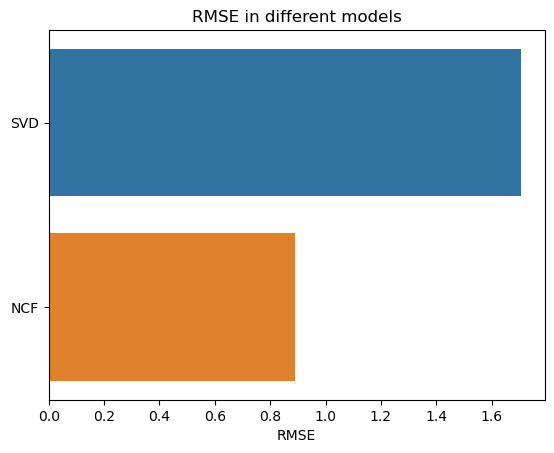

In [135]:
sns.barplot(x=[SVD1.RMSE,NCF1.RMSE],y=['SVD','NCF'])
plt.xlabel('RMSE')
plt.title('RMSE in different models')

The NCF performs better than SVD in variable "data".

let's see how the performance and running time change when sample size change, and compare two models.

In [136]:
import time
# get the data to plot line chart
# warning: this takes much time
rate = [1,1.5,2,2.5,3,4,5]
svd_rmse = []
ncf_rmse = []
svd_time = []
ncf_time = []
for i in range(len(rate)): # 7 samples
    p = rate[i]
    sample = get_sample(seed=40,popular_num=int(80*p),unpopular_num=int(20*p),active_num=int(400*p),unactive_num=int(100*p))
    svd_start = time.time()
    svd_rmse.append(SVD_recommend(data=sample).RMSE)
    svd_time.append(time.time()-svd_start)
    ncf_start = time.time()
    ncf_rmse.append(NCF_recommend(data=sample).RMSE)
    ncf_time.append(time.time()-ncf_start)

User: 500 Movie: 100
214/214 [==============================] - 0s 1ms/step
User: 748 Movie: 150
458/458 [==============================] - 1s 1ms/step
User: 997 Movie: 200
751/751 [==============================] - 1s 1ms/step
User: 1249 Movie: 250
1106/1106 [==============================] - 1s 1ms/step
User: 1499 Movie: 300
1442/1442 [==============================] - 2s 1ms/step
User: 2000 Movie: 400
2206/2206 [==============================] - 3s 1ms/step
User: 2500 Movie: 500
2939/2939 [==============================] - 4s 1ms/step


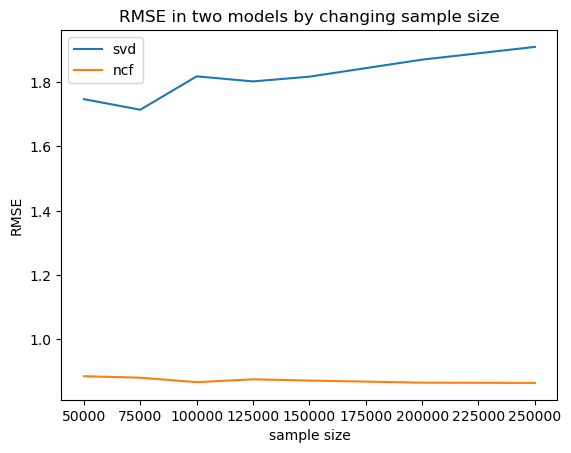

In [137]:
sample_size = [i * 100*500 for i in rate] 
sns.lineplot(x=sample_size,y=svd_rmse,label='svd')
sns.lineplot(x=sample_size,y=ncf_rmse,label='ncf')
plt.title('RMSE in two models by changing sample size')
plt.xlabel('sample size')
plt.ylabel('RMSE')
plt.show()

We can see with sample size changes, RMSE of NCF is still lower than it of SVD.  
RMSE of NCF goes down a little with sample size becomes larger. It's because more data provide more information, and can improve model performance.  
RMSE of SVD shows an increasing trend with sample size becomes larger. We guess that the reason could be the svd model we constructed has overfitting and other problems.

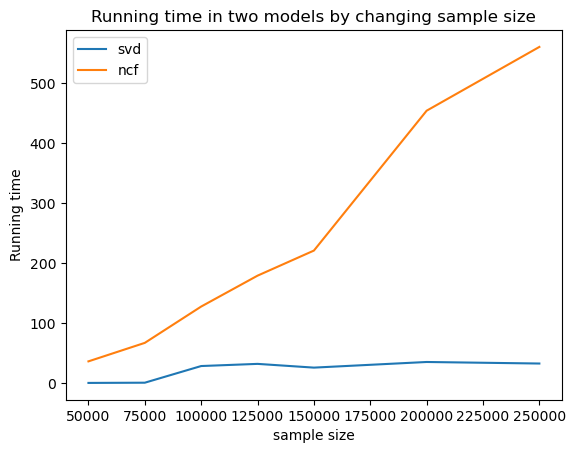

In [138]:
sns.lineplot(x=sample_size,y=svd_time,label='svd')
sns.lineplot(x=sample_size,y=ncf_time,label='ncf')
plt.title('Running time in two models by changing sample size')
plt.xlabel('sample size')
plt.ylabel('Running time')
plt.show()

It can be seen that the NCF model runs longer than the SVD model.  
In addition, as the sample size increases, the NCF running time grows faster than the SVD running time. This is because our NCF model is more complex than our SVD model.

In [139]:
ncf_rmse2 = []
svd_rmse2 = []
for i in range(10): # 10 samples
    sample = get_sample(seed=i,popular_num=80,unpopular_num=20,active_num=400,unactive_num=100)
    ncf_rmse2.append(NCF_recommend(data=sample).RMSE)
    svd_rmse2.append(SVD_recommend(data=sample).RMSE)

User: 500 Movie: 100
210/210 [==============================] - 0s 2ms/step
User: 499 Movie: 100
214/214 [==============================] - 0s 1ms/step
User: 498 Movie: 100
212/212 [==============================] - 0s 1ms/step
User: 497 Movie: 100
211/211 [==============================] - 0s 1ms/step
User: 499 Movie: 100
219/219 [==============================] - 0s 1ms/step
User: 498 Movie: 100
209/209 [==============================] - 0s 1ms/step
User: 493 Movie: 100
213/213 [==============================] - 0s 1ms/step
User: 498 Movie: 100
209/209 [==============================] - 1s 2ms/step
User: 498 Movie: 100
211/211 [==============================] - 0s 2ms/step
User: 499 Movie: 100
213/213 [==============================] - 0s 2ms/step


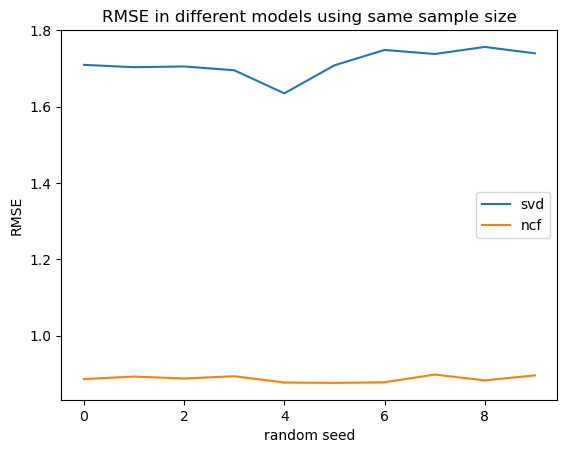

In [140]:
seeds = range(10)
sns.lineplot(x=seeds,y=svd_rmse2,label='svd')
sns.lineplot(x=seeds,y=ncf_rmse2,label='ncf')
plt.title('RMSE in different models using same sample size')
plt.xlabel('random seed')
plt.ylabel('RMSE')
plt.show()

We can see whatever random seed changes, NCF performs better than SVD.

# 8. Ensemble Model 
We are predicting an integer value, so the ensemble should contain:
- A “count” regression model
- a KNN regressor
- an SVM regressor
- a decision tree regressor

In [141]:
data[['UserID','MovieID','Rating']]

,UserID,MovieID,Rating
0,306466,30,3.000
1,1174530,30,4.000
2,1744889,30,3.000
3,461110,30,4.000
4,327122,30,4.000
...,...,...,...
34280,953604,4472,5.000
34281,464774,4472,3.000
34282,411160,4472,4.000
34283,1561134,4472,5.000


Split dataset into train and test

In [142]:
X_train, X_test, y_train, y_test = train_test_split(data[['UserID','MovieID']], data['Rating'], test_size=0.2, random_state=40)

Build model

In [143]:
# initialize
linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=151)
svm_model = SVR()
decision_tree_model = DecisionTreeRegressor(max_depth=7, random_state=40)

In [144]:
# ensemble
ensemble_model = VotingRegressor(
    estimators=[
        ('linear', linear_model),
        ('knn', knn_model),
        ('svm', svm_model),
        ('decision_tree', decision_tree_model)
    ],
    n_jobs=-1,
    weights = [1, 8, 3, 8]
)

We set weights of four models, The linear regression performs bad so we reduce its weight, and decision tree should perform good so we increase its weight.

In [145]:
# fit
ensemble_model.fit(X_train, y_train)

# evaluate
ensemble_score = ensemble_model.score(X_test, y_test)

In [146]:
y_pre = ensemble_model.predict(X_test)
MSE = mean_squared_error(y_test,y_pre)
RMSE = MSE ** 0.5
RMSE

1.0500814686461661

The final result is decided by all four models. Each model predict rating values independently and calculate weighted average as final result.  

The ensemble model performs better than SVD, but worse than NCF which we selected as preferred model.  
Here are reasons we guess:
- There is no linear relation between features and the response variable. So linear regression performs bad.
- Although KNN, SVM and decision tree algorithms can handle with non-linear relation, they are not as powerful as neural network in this project.


# 9. conclusion

In conclusion, the project has undertaken a comprehensive approach to enhance Netflix's movie recommendation system, with a focus on optimizing user engagement and satisfaction. The team employed a hybrid deep learning model, combining collaborative filtering, content-based features, and matrix factorization techniques. Through exploratory data analysis (EDA), data preparation, and the creation of a user rating matrix, the project laid the foundation for meaningful insights and model development.

To address the first research question, the team explored various recommendation models, including collaborative filtering using Neural Collaborative Filtering (NCF), matrix factorization using TruncatedSVD, and collaborative filtering with the Surprise library's SVD. These models, along with the weighted average and popularity-based recommendation system, contribute to a holistic approach in delivering accurate and diverse movie suggestions to users.

For the second research question, we set hyperparameters including Learning Rate, Network Architecture, Regularization Parameters, Dropout Rate and Batch Size and Epochs.

For the third research question, we created a bar chart and three line charts to visualize performance on different models.

The hybrid approach, content-based recommendations, and fine-tuning of critical hyperparameters collectively contribute to a more nuanced and effective movie recommendation system. By striking a balance between user preferences and popular trends, the project aims to provide users with an enriched and personalized streaming experience, fostering increased engagement and satisfaction within the Netflix platform.

## reference 
https://www.kaggle.com/netflix-inc/netflix-prize-data  
https://pandas.pydata.org/pandas-docs/stable/index.html  
https://numpy.org/doc/   
https://seaborn.pydata.org/  
https://matplotlib.org/  
https://www.tensorflow.org/overview  
https://keras.io/  
https://en.wikipedia.org/wiki/Collaborative_filtering  
https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering  
https://scikit-learn.org/stable/documentation.html  
https://github.com/devaramv/netflix-prize-dataset-analysis/blob/master/Documentation.md  
https://github.com/SurajChoudhary/Netflix-Prize-Dataset-Analysis  